In [591]:
import os
import csv
from collections import defaultdict, Counter
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, mannwhitneyu, ttest_ind
import matplotlib.gridspec as gridspec
import math
from scipy.stats import zscore

In [550]:
LOGS = '/mnt/data0/lucy/gpt3_bias/logs/'
prompts_path = LOGS + 'original_prompts/'

## Character name popularity

In [5]:
def get_named_entities(char_neighbor_path): 
    '''
    Count named entities once per story
    '''
    named_people = Counter()
    for f in os.listdir(char_neighbor_path):
        all_people = set()
        with open(char_neighbor_path + f, 'r') as infile: 
            char_neighbors = json.load(infile)
        for char in char_neighbors: 
            neighbor_dict = char_neighbors[char]
            for neighbor in neighbor_dict: 
                all_people.add(neighbor['character_name'])
                for al in neighbor['aliases']: 
                    all_people.add(al)
        for person in all_people: 
            name = '_'.join(person.split('_')[:-1])
            named_people[name] += 1
    return named_people

In [4]:
def plot_popular_names(char_neighbor_path, title): 
    plt.figure(dpi=150, figsize=(6,6))
    people = get_named_entities(char_neighbor_path)
    total_names = sum(list(people.values()))
    labels = []
    values = []
    for tup in people.most_common(20): 
        labels.append(tup[0])
        values.append(tup[1]/total_names)
    labels = labels[::-1]
    values = values[::-1]
    x = np.arange(len(labels))
    plt.barh(x, values, 0.7)
    plt.xlabel('Percentage of names')
    plt.title(title)
    plt.yticks(x, labels=labels, fontsize=12)
    plt.show()

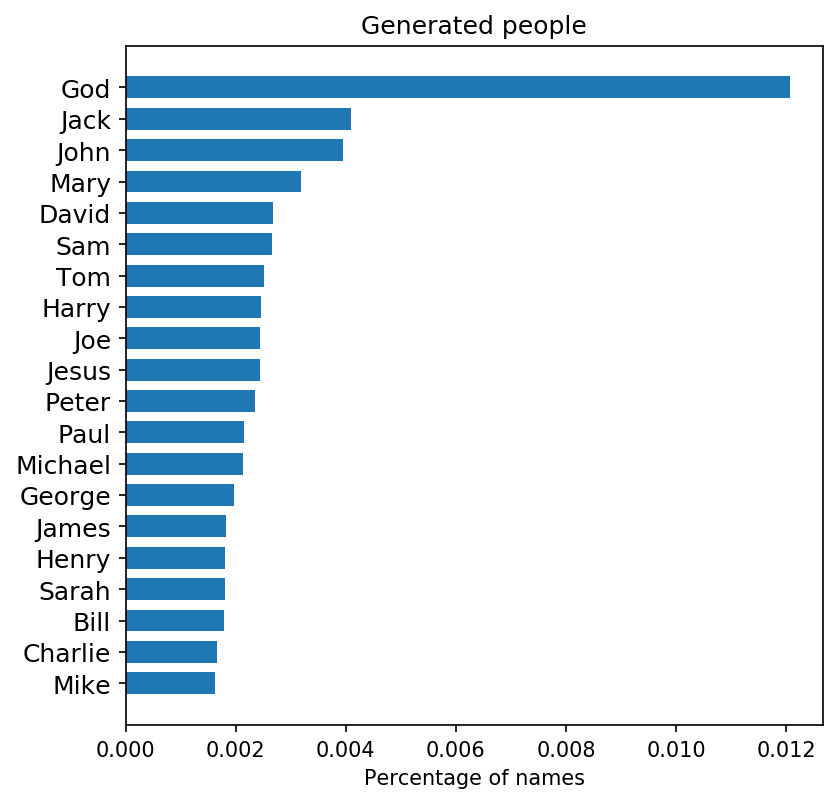

In [5]:
plot_popular_names(LOGS + 'char_neighbors_0.9/', 'Generated people')

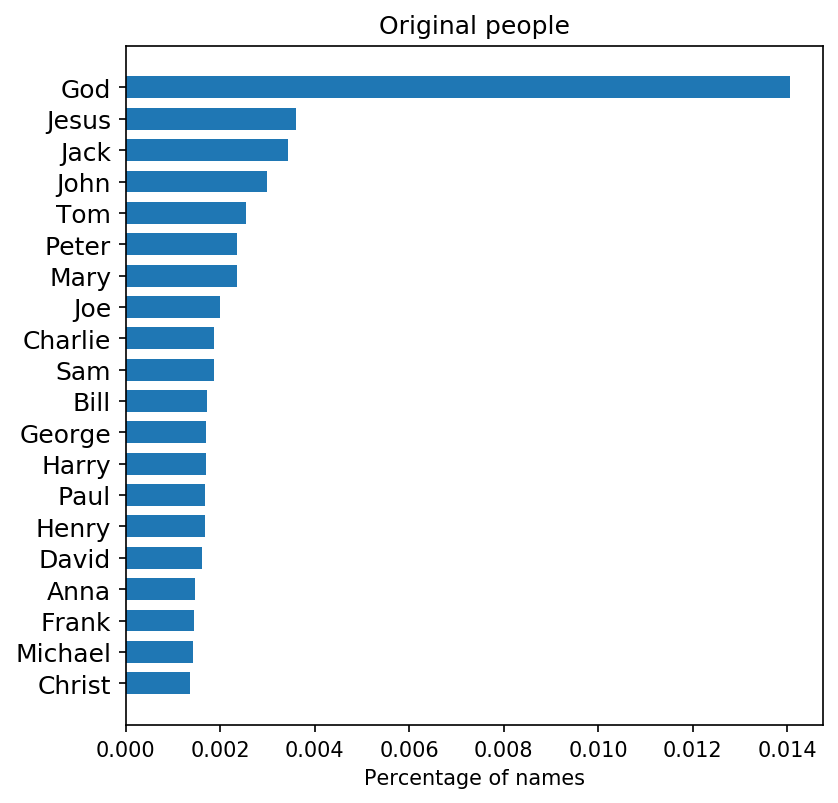

In [6]:
plot_popular_names(LOGS + 'orig_char_neighbors/', 'Original people')

### Main characters

In [209]:
def get_main_char(char_neighbor_path, dataset): 
    # gender type is "name" or "pronouns"
    d = {'dataset':[], 'gender':[]}
    all_n_genders = ['mixed pronouns', 'other (name)', 'masc (name)', 'fem (name)', 'fem', 'masc']
    for title in os.listdir(prompts_path): 
        if not os.path.exists(char_neighbor_path + title + '.json'): continue
        with open(char_neighbor_path + title + '.json', 'r') as infile: 
            char_neighbors = json.load(infile)
        for char in char_neighbors: 
            # for every main character
            neighbor_dict = char_neighbors[char]
            for neighbor in neighbor_dict: 
                # for every character it co-occurs with 
                gender = neighbor['gender_label']
                neighbor_n = neighbor['character_name']
                pronoun_count = len(neighbor['gender'])
                if pronoun_count == 0 and not gender.startswith('mixed') and not gender.endswith('(name)'): 
                    gender += ' (name)'
                story_ID = int(neighbor_n.split('_')[-1])
                is_main = False
                if neighbor_n.startswith(char + '_'): 
                    # main character
                    is_main = True
                else: 
                    for al in neighbor['aliases']: 
                        if al == char: 
                            is_main = True
                if is_main: 
                    d['gender'].append(gender)
                    d['dataset'].append(dataset)
                    continue
    return d

In [210]:
main_gen_d = get_main_char(LOGS + 'char_gender_0.9/', 'generated')
main_gen_df = pd.DataFrame.from_dict(main_gen_d)
main_orig_d = get_main_char(LOGS + 'orig_char_gender/', 'books')
main_orig_df = pd.DataFrame.from_dict(main_orig_d)
main_df = pd.concat([main_gen_df, main_orig_df])
main_df

,dataset,gender
0,generated,other (name)
1,generated,masc
2,generated,masc
3,generated,other (name)
4,generated,other (name)
...,...,...
21701,books,fem (name)
21702,books,fem
21703,books,fem
21704,books,fem


In [211]:
main_stats = main_df.groupby(['dataset', 'gender']).size()
main_stats

dataset    gender        
books      fem                5858
           fem (name)          928
           masc              11080
           masc (name)        2168
           mixed pronouns     1551
           other (name)        121
generated  fem               30054
           fem (name)         4070
           masc              52938
           masc (name)        7804
           mixed pronouns     6486
           other (name)       6984
dtype: int64

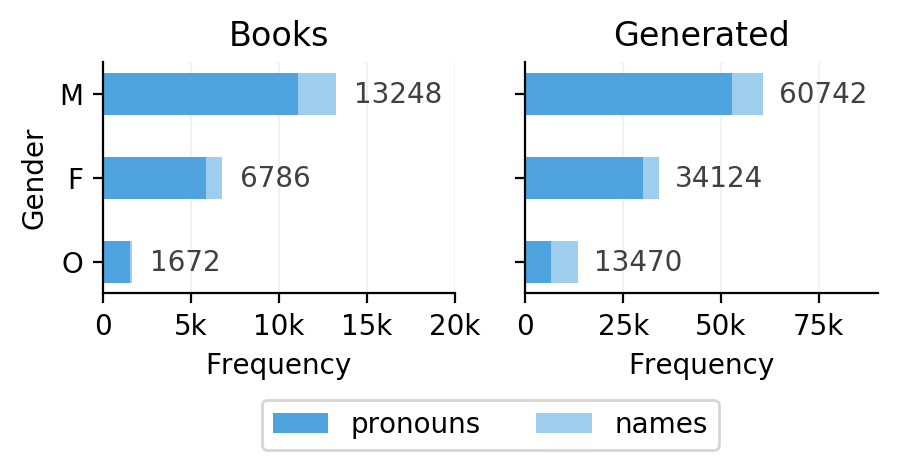

In [370]:
def format_func(value, tick_number):
    # find number of multiples of pi/2
    if value == 0: 
        return 0
    num = str(value / 1000)
    if num.endswith('.0'): 
        num = num.replace('.0', '')
    return num + 'k'

pronoun_books = [main_stats.loc['books'].loc['masc'], 
                 main_stats.loc['books'].loc['fem'], 
                 main_stats.loc['books'].loc['mixed pronouns']]
pronoun_generated = [main_stats.loc['generated'].loc['masc'], 
                 main_stats.loc['generated'].loc['fem'], 
                 main_stats.loc['generated'].loc['mixed pronouns']]
name_books = [main_stats.loc['books'].loc['masc (name)'], 
                 main_stats.loc['books'].loc['fem (name)'], 
                 main_stats.loc['books'].loc['other (name)']]
name_generated = [main_stats.loc['generated'].loc['masc (name)'], 
                 main_stats.loc['generated'].loc['fem (name)'], 
                 main_stats.loc['generated'].loc['other (name)']]
bar_width = 0.5
labels = ['O', 'F', 'M']
fig, axes = plt.subplots(1, 2, figsize=(5, 1.5), dpi=200)
axes[0].set_xlim(0, 20000)
axes[0].set_axisbelow(True)
axes[0].grid(axis='x', color='0.95')
axes[0].barh(labels, pronoun_books[::-1], bar_width, 
       label='pronouns', color='#4fa4e0')
axes[0].barh(labels, name_books[::-1], bar_width, left=pronoun_books[::-1], 
       label='names', color='#9fcded')
axes[0].set_ylabel('Gender')
axes[0].set_title('Books')
axes[0].set_xlabel('Frequency')
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
for i in range(1, 4):
    axes[0].text(pronoun_books[-i] + name_books[-i] + 1000, i-1-0.18,
                pronoun_books[-i] + name_books[-i], ha='left', va='bottom', color='0.25')

axes[1].set_axisbelow(True)
axes[1].set_xlim(0, 90000)
axes[1].grid(axis='x', color='0.95')
axes[1].barh(labels, pronoun_generated[::-1], bar_width, 
       label='pronouns', color='#4fa4e0')
axes[1].barh(labels, name_generated[::-1], bar_width, left=pronoun_generated[::-1], 
       label='names', color='#9fcded')
axes[1].set_title('Generated')
axes[1].set_xlabel('Frequency')
axes[1].legend(loc='upper center', ncol=2, bbox_to_anchor=(-0.1, -0.4))
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
for i in range(1, 4):
    axes[1].text(pronoun_generated[-i] + name_generated[-i] + 4000, i-1-0.18,
                pronoun_generated[-i] + name_generated[-i], ha='left', va='bottom', color='0.25')
axes[1].get_yaxis().set_ticklabels([])
sns.despine()
plt.show()

## Character networks

What types of characters do prompt characters co-occur with? 

In [201]:
def get_char_network(char_neighbor_path): 
    # gender type is "name" or "pronouns"
    d = {'main_gender':[], 'fem prop':[], 'masc prop':[], 'mixed pronouns prop':[], 
        'other (name) prop': [], 'masc (name) prop': [], 'fem (name) prop': []}
    all_n_genders = ['mixed pronouns', 'other (name)', 'masc (name)', 'fem (name)', 'fem', 'masc']
    for title in os.listdir(prompts_path): 
        if not os.path.exists(char_neighbor_path + title + '.json'): continue
        with open(char_neighbor_path + title + '.json', 'r') as infile: 
            char_neighbors = json.load(infile)
        for char in char_neighbors: 
            # for every main character
            main_char_gender = defaultdict(str) # story ID to gender
            neighbor_dict = char_neighbors[char]
            neighbor_genders = defaultdict(list) # story ID to neighbor genders
            for neighbor in neighbor_dict: 
                # for every character it co-occurs with 
                gender = neighbor['gender_label']
                neighbor_n = neighbor['character_name']
                pronoun_count = len(neighbor['gender'])
                story_ID = int(neighbor_n.split('_')[-1])
                is_main = False
                if neighbor_n.startswith(char + '_'): 
                    # main character
                    is_main = True
                else: 
                    for al in neighbor['aliases']: 
                        if al == char: 
                            is_main = True
                if is_main: 
                    if gender.startswith('mixed') or gender.startswith('other'): 
                        gender = 'other'
                    main_char_gender[story_ID] = gender
                    continue
                
                # note that in books, you can have no pronouns but gender label of mixed pronouns
                # because you might be using pronouns from another excerpt 
                if pronoun_count == 0 and gender != 'mixed pronouns' and not gender.endswith('(name)'): 
                    gender += ' (name)'
                neighbor_genders[story_ID].append(gender)
                
            for story_ID in main_char_gender: 
                main_g = main_char_gender[story_ID]
                n_genders = Counter(neighbor_genders[story_ID])
                total = sum(list(n_genders.values()))
                if total == 0: continue
                d['main_gender'].append(main_g)
                for gender in all_n_genders: 
                    d[gender + ' prop'].append(n_genders[gender] / total)
    return d

In [202]:
gen_d = get_char_network(LOGS + 'char_gender_0.9/')
gen_df = pd.DataFrame.from_dict(gen_d)
gen_stats = gen_df.groupby(['main_gender']).agg(['mean', 'count', 'std'])
gen_df

,main_gender,fem prop,masc prop,mixed pronouns prop,other (name) prop,masc (name) prop,fem (name) prop
0,other,0.166667,0.333333,0.0,0.000000,0.333333,0.166667
1,masc,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,masc,0.000000,0.200000,0.0,0.200000,0.200000,0.400000
3,other,0.000000,0.500000,0.0,0.300000,0.100000,0.100000
4,other,0.333333,0.333333,0.0,0.000000,0.333333,0.000000
...,...,...,...,...,...,...,...
103117,masc,0.166667,0.500000,0.0,0.333333,0.000000,0.000000
103118,fem,0.000000,0.000000,0.0,1.000000,0.000000,0.000000
103119,fem,0.000000,0.384615,0.0,0.153846,0.230769,0.230769
103120,fem,0.363636,0.272727,0.0,0.181818,0.000000,0.181818


In [203]:
orig_d = get_char_network(LOGS + 'orig_char_gender/')
orig_df = pd.DataFrame.from_dict(orig_d)
orig_stats = orig_df.groupby(['main_gender']).agg(['mean', 'count', 'std'])
orig_df

,main_gender,fem prop,masc prop,mixed pronouns prop,other (name) prop,masc (name) prop,fem (name) prop
0,other,0.375000,0.250000,0.062500,0.062500,0.250000,0.000000
1,other,0.000000,0.153846,0.076923,0.384615,0.230769,0.153846
2,other,0.500000,0.000000,0.250000,0.250000,0.000000,0.000000
3,other,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000
4,other,0.454545,0.000000,0.090909,0.090909,0.181818,0.181818
...,...,...,...,...,...,...,...
21440,fem,0.142857,0.285714,0.142857,0.000000,0.428571,0.000000
21441,fem,0.181818,0.181818,0.000000,0.090909,0.090909,0.454545
21442,fem,0.200000,0.200000,0.100000,0.000000,0.200000,0.300000
21443,fem,0.125000,0.250000,0.125000,0.000000,0.375000,0.125000


In [204]:
orig_stats

fem prop                  masc prop                   \
                 mean  count       std      mean  count       std   
main_gender                                                         
fem          0.186799   6714  0.166510  0.276338   6714  0.193413   
masc         0.145061  13081  0.163153  0.297833  13081  0.195305   
other        0.165692   1650  0.172796  0.280790   1650  0.196426   

            mixed pronouns prop                  other (name) prop         \
                           mean  count       std              mean  count   
main_gender                                                                 
fem                    0.047930   6714  0.098867          0.107870   6714   
masc                   0.042718  13081  0.087942          0.121072  13081   
other                  0.072276   1650  0.120110          0.124338   1650   

                      masc (name) prop                  fem (name) prop  \
                  std             mean  count       std            mean   
main_gender                                                               
fem          0.131302         0.231731   6714  0.175801        0.149332   
masc         0.139076         0.286404  13081  0.190175        0.106913   
other        0.146530         0.239487   1650  0.188254        0.117417   

                              
             count       std  
main_gender                   
fem           6714  0.150319  
masc         13081  0.134184  
other         1650  0.143890

In [205]:
def get_values(gender, stats):
    '''
    gender is main character gender, such as 'fem', 'masc', or 'other'
    '''
    c = stats.loc[gender].loc['fem prop'].loc['count']
    name_means = [stats.loc[gender].loc['masc (name) prop'].loc['mean'], 
                  stats.loc[gender].loc['fem (name) prop'].loc['mean'], 
                  stats.loc[gender].loc['other (name) prop'].loc['mean']]
    name_ci = [stats.loc[gender].loc['masc (name) prop'].loc['std'], 
                  stats.loc[gender].loc['fem (name) prop'].loc['std'], 
                  stats.loc[gender].loc['other (name) prop'].loc['std']]
    for i in range(len(labels)): 
        name_ci[i] = 1.96*name_ci[i]/math.sqrt(c)
    pronoun_means = [stats.loc[gender].loc['masc prop'].loc['mean'], 
                     stats.loc[gender].loc['fem prop'].loc['mean'], 
                     stats.loc[gender].loc['mixed pronouns prop'].loc['mean']]
    pronoun_ci = [stats.loc[gender].loc['masc prop'].loc['std'], 
                     stats.loc[gender].loc['fem prop'].loc['std'], 
                     stats.loc[gender].loc['mixed pronouns prop'].loc['std']]
    for i in range(len(labels)): 
        pronoun_ci[i] = 1.96*pronoun_ci[i]/math.sqrt(c)
    return name_means, name_ci, pronoun_means, pronoun_ci

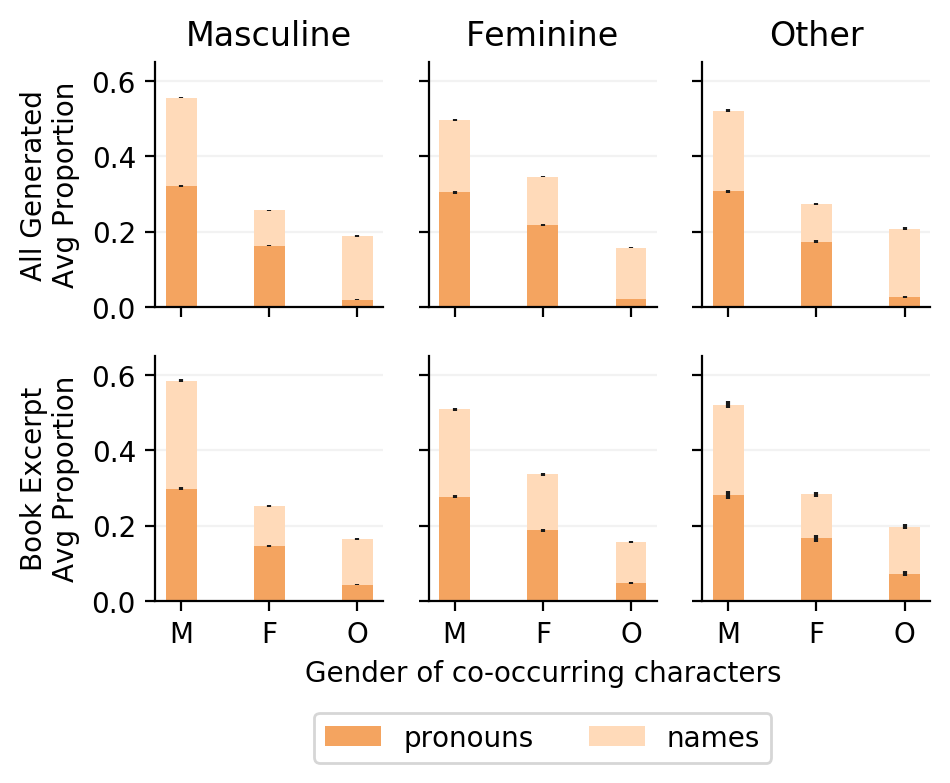

In [206]:
# https://matplotlib.org/3.3.3/gallery/lines_bars_and_markers/bar_stacked.html
fig, axes = plt.subplots(2, 3, figsize=(5, 3.5), dpi=200)
bar_width = 0.35
for i in range(2): 
    for j in range(3): 
        axes[i][j].set_ylim(0, 0.65)
labels = ['M', 'F', 'O']

name_means, name_ci, pronoun_means, pronoun_ci = get_values('masc', gen_stats)
axes[0][0].set_axisbelow(True)
axes[0][0].grid(axis='y', color='0.95')
axes[0][0].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[0][0].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')
axes[0][0].set_ylabel('All Generated\nAvg Proportion')
axes[0][0].set_title('Masculine')
axes[0][0].get_xaxis().set_ticklabels([])

name_means, name_ci, pronoun_means, pronoun_ci = get_values('fem', gen_stats)
axes[0][1].set_axisbelow(True)
axes[0][1].grid(axis='y', color='0.95')
axes[0][1].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[0][1].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')
axes[0][1].get_yaxis().set_ticklabels([])
axes[0][1].set_title('Feminine')
axes[0][1].get_xaxis().set_ticklabels([])

name_means, name_ci, pronoun_means, pronoun_ci = get_values('other', gen_stats)
axes[0][2].set_axisbelow(True)
axes[0][2].grid(axis='y', color='0.95')
axes[0][2].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[0][2].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')
axes[0][2].get_yaxis().set_ticklabels([])
axes[0][2].set_title('Other')
axes[0][2].get_xaxis().set_ticklabels([])

name_means, name_ci, pronoun_means, pronoun_ci = get_values('masc', orig_stats)
axes[1][0].set_axisbelow(True)
axes[1][0].grid(axis='y', color='0.95')
axes[1][0].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[1][0].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')
axes[1][0].set_ylabel('Book Excerpt\nAvg Proportion')

name_means, name_ci, pronoun_means, pronoun_ci = get_values('fem', orig_stats)
axes[1][1].set_axisbelow(True)
axes[1][1].grid(axis='y', color='0.95')
axes[1][1].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[1][1].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')
axes[1][1].get_yaxis().set_ticklabels([])
axes[1][1].set_xlabel('Gender of co-occurring characters')
axes[1][1].legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.4))

name_means, name_ci, pronoun_means, pronoun_ci = get_values('other', orig_stats)
axes[1][2].set_axisbelow(True)
axes[1][2].grid(axis='y', color='0.95')
axes[1][2].bar(labels, pronoun_means, bar_width, yerr=pronoun_ci, 
       label='pronouns', color='sandybrown')
axes[1][2].bar(labels, name_means, bar_width, yerr=name_ci, bottom=pronoun_means, 
       label='names', color='peachpuff')
axes[1][2].get_yaxis().set_ticklabels([])

sns.despine()
plt.show()

In [207]:
# main character genders
print("Women:", gen_d['main_gender'].count('fem'), gen_d['main_gender'].count('fem')/len(gen_d['main_gender']))
print("Men:", gen_d['main_gender'].count('masc'), gen_d['main_gender'].count('masc')/len(gen_d['main_gender']))
print("Other:", gen_d['main_gender'].count('other'), gen_d['main_gender'].count('other')/len(gen_d['main_gender']))
print("Total:", len(gen_d['main_gender']))

Women: 32527 0.31542250926087545
Men: 57822 0.5607144935125385
Other: 12773 0.12386299722658599
Total: 103122


In [208]:
# main character genders
print("Women:", orig_d['main_gender'].count('fem'), orig_d['main_gender'].count('fem')/len(orig_d['main_gender']))
print("Men:", orig_d['main_gender'].count('masc'), orig_d['main_gender'].count('masc')/len(orig_d['main_gender']))
print("Other:", orig_d['main_gender'].count('other'), orig_d['main_gender'].count('other')/len(orig_d['main_gender']))
print("Total:", len(orig_d['main_gender']))

Women: 6714 0.3130799720214502
Men: 13081 0.6099790160876661
Other: 1650 0.07694101189088366
Total: 21445


## Topics

In [349]:
def get_topic_by_dataset():
    topic_dir = LOGS + 'topics_0.9'
    doc_topic_file = '%s/doc-topics.gz' % topic_dir
    doc_topics = open(doc_topic_file).read().splitlines() # list of topics
    story_ids = open(topic_dir + '/story_id_order').read().splitlines() # story IDs 
    data_topics = {'dataset':[], 'topic':[], 'value':[]}
    for i, doc in enumerate(doc_topics): 
        contents = doc.split('\t')
        topics = [float(i) for i in contents[2:]]
        story_title_id = story_ids[i]             
        assert len(topics) == 50
        for topic_id, value in enumerate(topics): 
            if story_title_id.startswith('ORIG_'):
                data_topics['dataset'].append('original')
            else: 
                data_topics['dataset'].append('generated')
            data_topics['topic'].append(topic_id)
            data_topics['value'].append(value)
    return data_topics

Plot all 50 topics and compare across datasets and genders

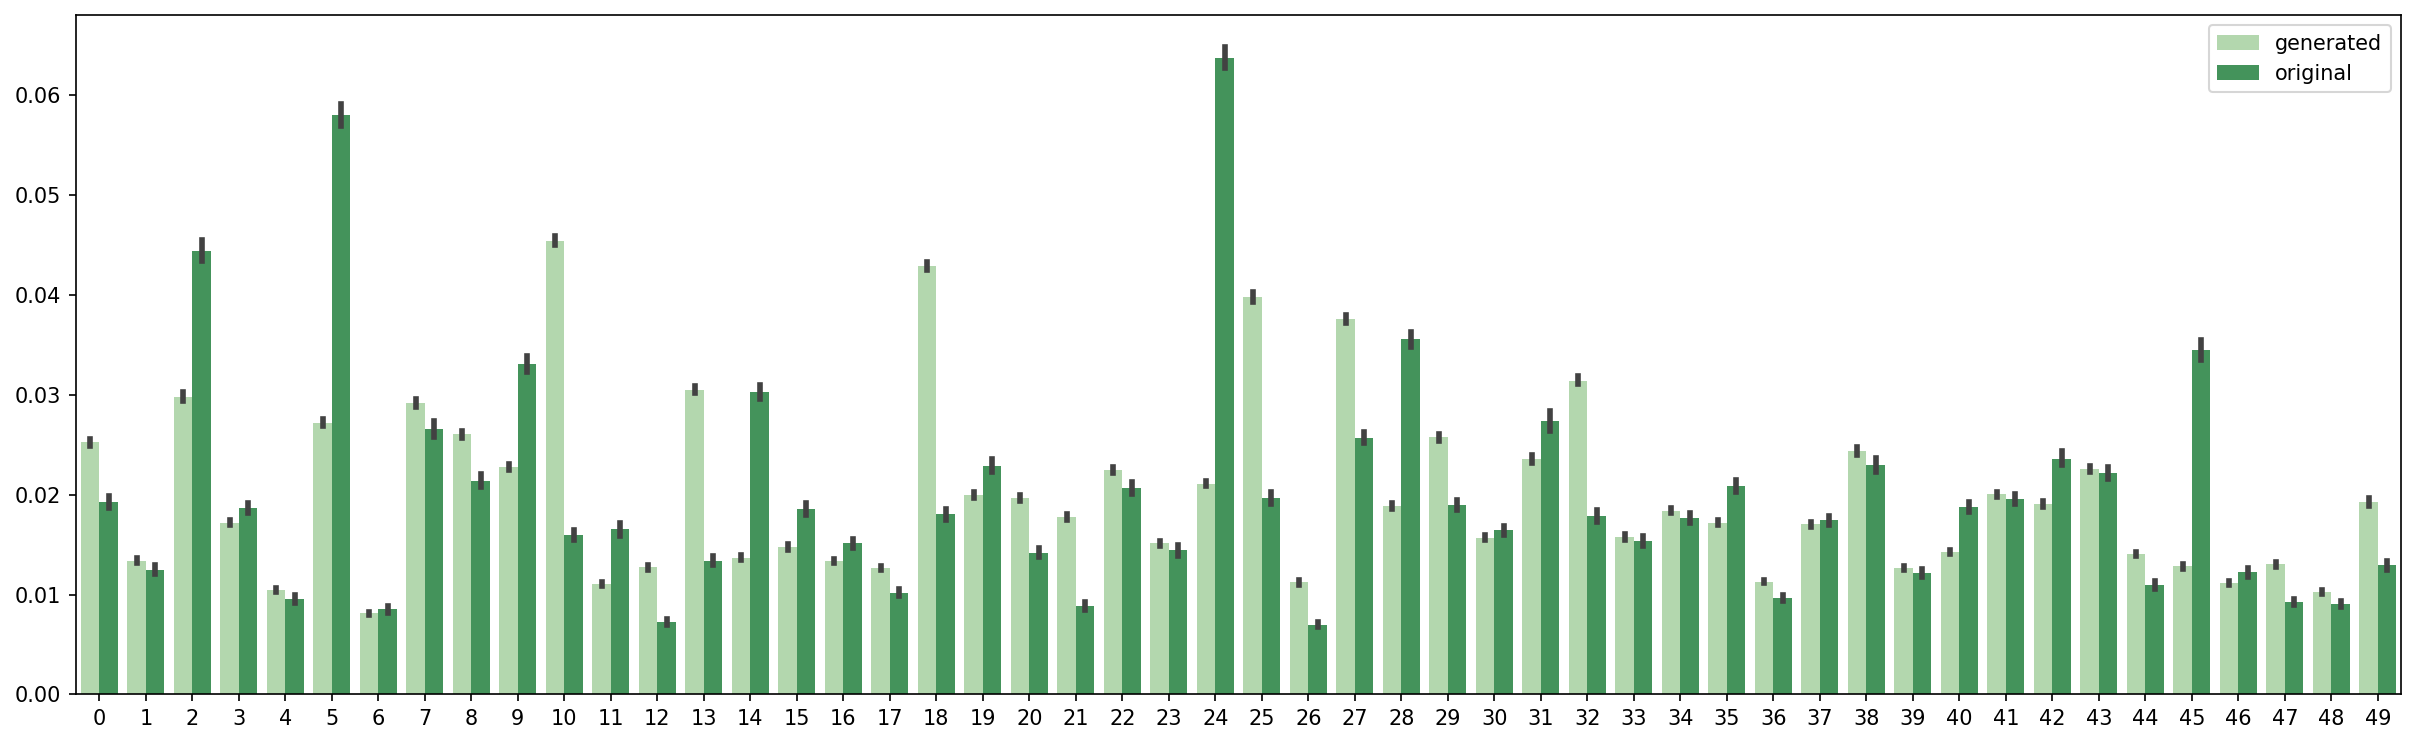

In [315]:
data_topics = get_topic_by_dataset()
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Greens", hue="dataset", data=data_topics)

In [645]:
with open(LOGS + 'gender_topics_0.9.json', 'r') as infile: 
    gen_gender_topics = json.load(infile)
with open(LOGS + 'orig_gender_topics.json', 'r') as infile: 
    orig_gender_topics = json.load(infile)
with open(LOGS + 'gender_topics_0.9_matched.json', 'r') as infile: 
    matched_gender_topics = json.load(infile)

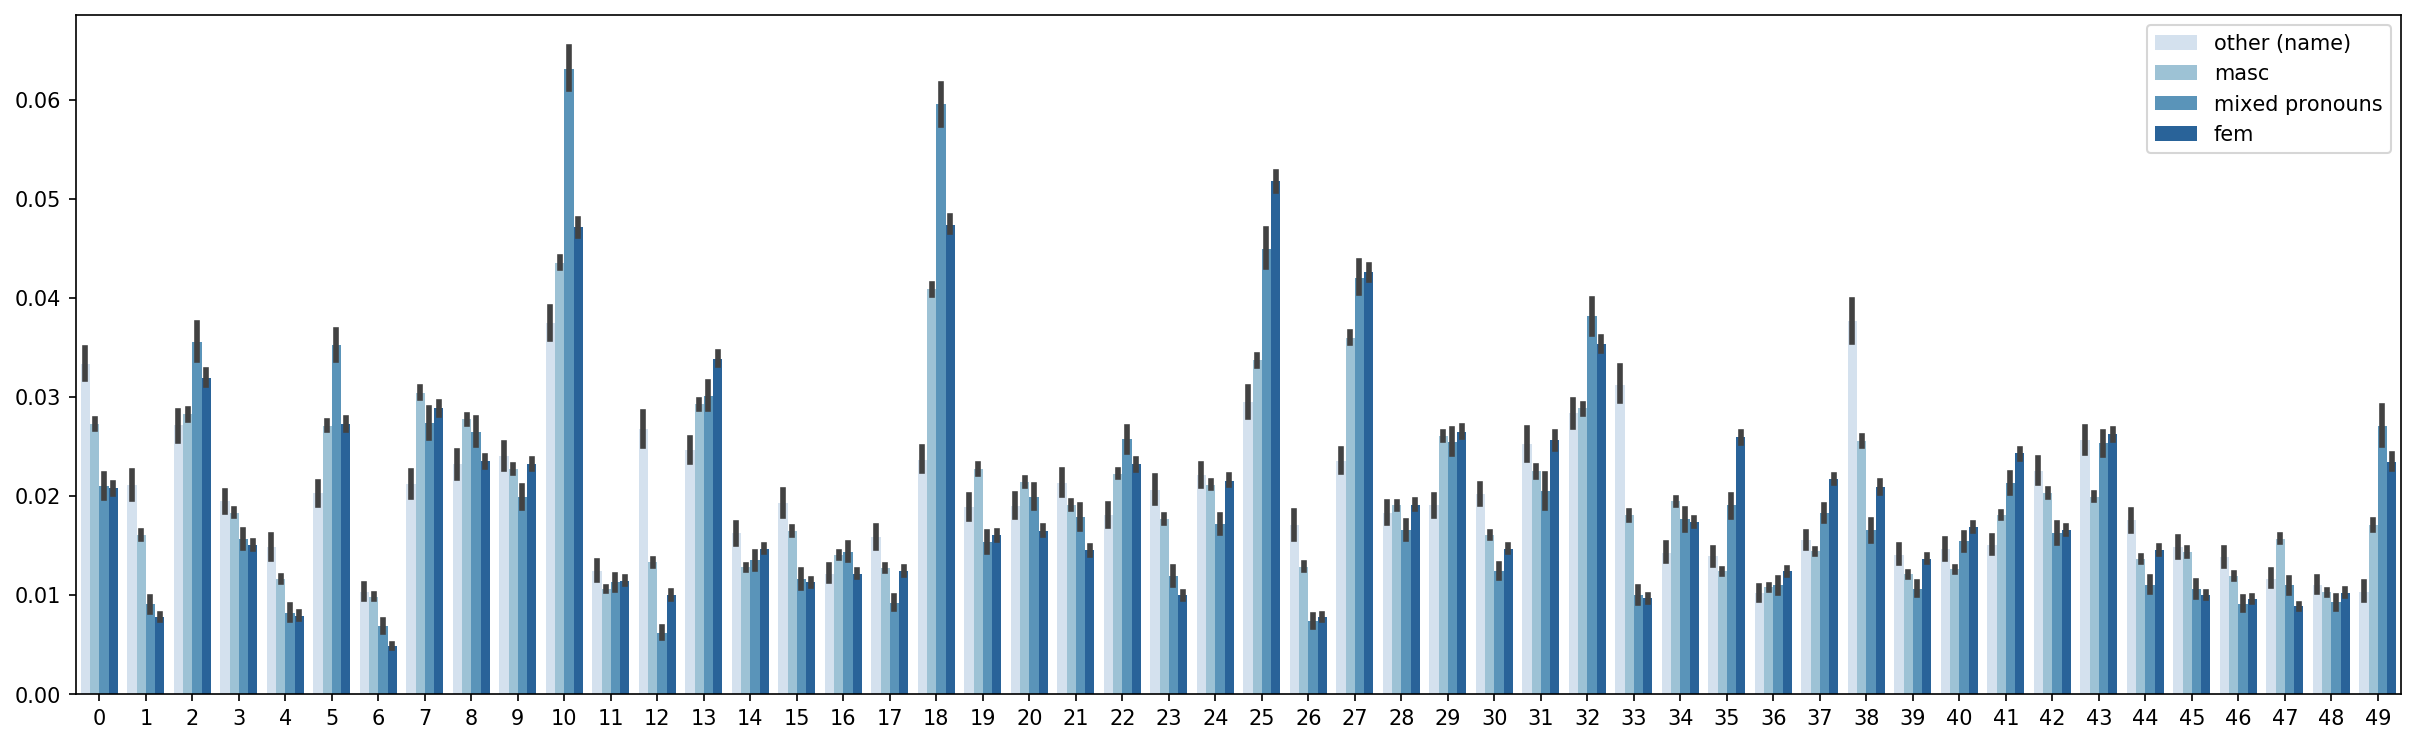

In [317]:
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Blues", hue="gender", data=gen_gender_topics)

In [658]:
# bonferroni correction: 0.05/12, or 0.00417
gen_gender_df = pd.DataFrame(gen_gender_topics)
for i in [33, 1, 23, 37, 35, 25]: 
    fem_prob = gen_gender_df.loc[(gen_gender_df.gender == 'fem') & (gen_gender_df.topic == i)]['value'].to_list()
    masc_prob = gen_gender_df.loc[(gen_gender_df.gender == 'masc') & (gen_gender_df.topic == i)]['value'].to_list()
    print(i, ttest_ind(fem_prob, masc_prob))

33 Ttest_indResult(statistic=-25.242334562404725, pvalue=4.028466723785765e-140)
1 Ttest_indResult(statistic=-29.045209391407248, pvalue=1.159707049355594e-184)
23 Ttest_indResult(statistic=-25.40809018098356, pvalue=6.188189751485186e-142)
37 Ttest_indResult(statistic=30.234010772416838, pvalue=7.688181205195763e-200)
35 Ttest_indResult(statistic=47.3506009760102, pvalue=0.0)
25 Ttest_indResult(statistic=33.67979375524103, pvalue=3.391909824492301e-247)


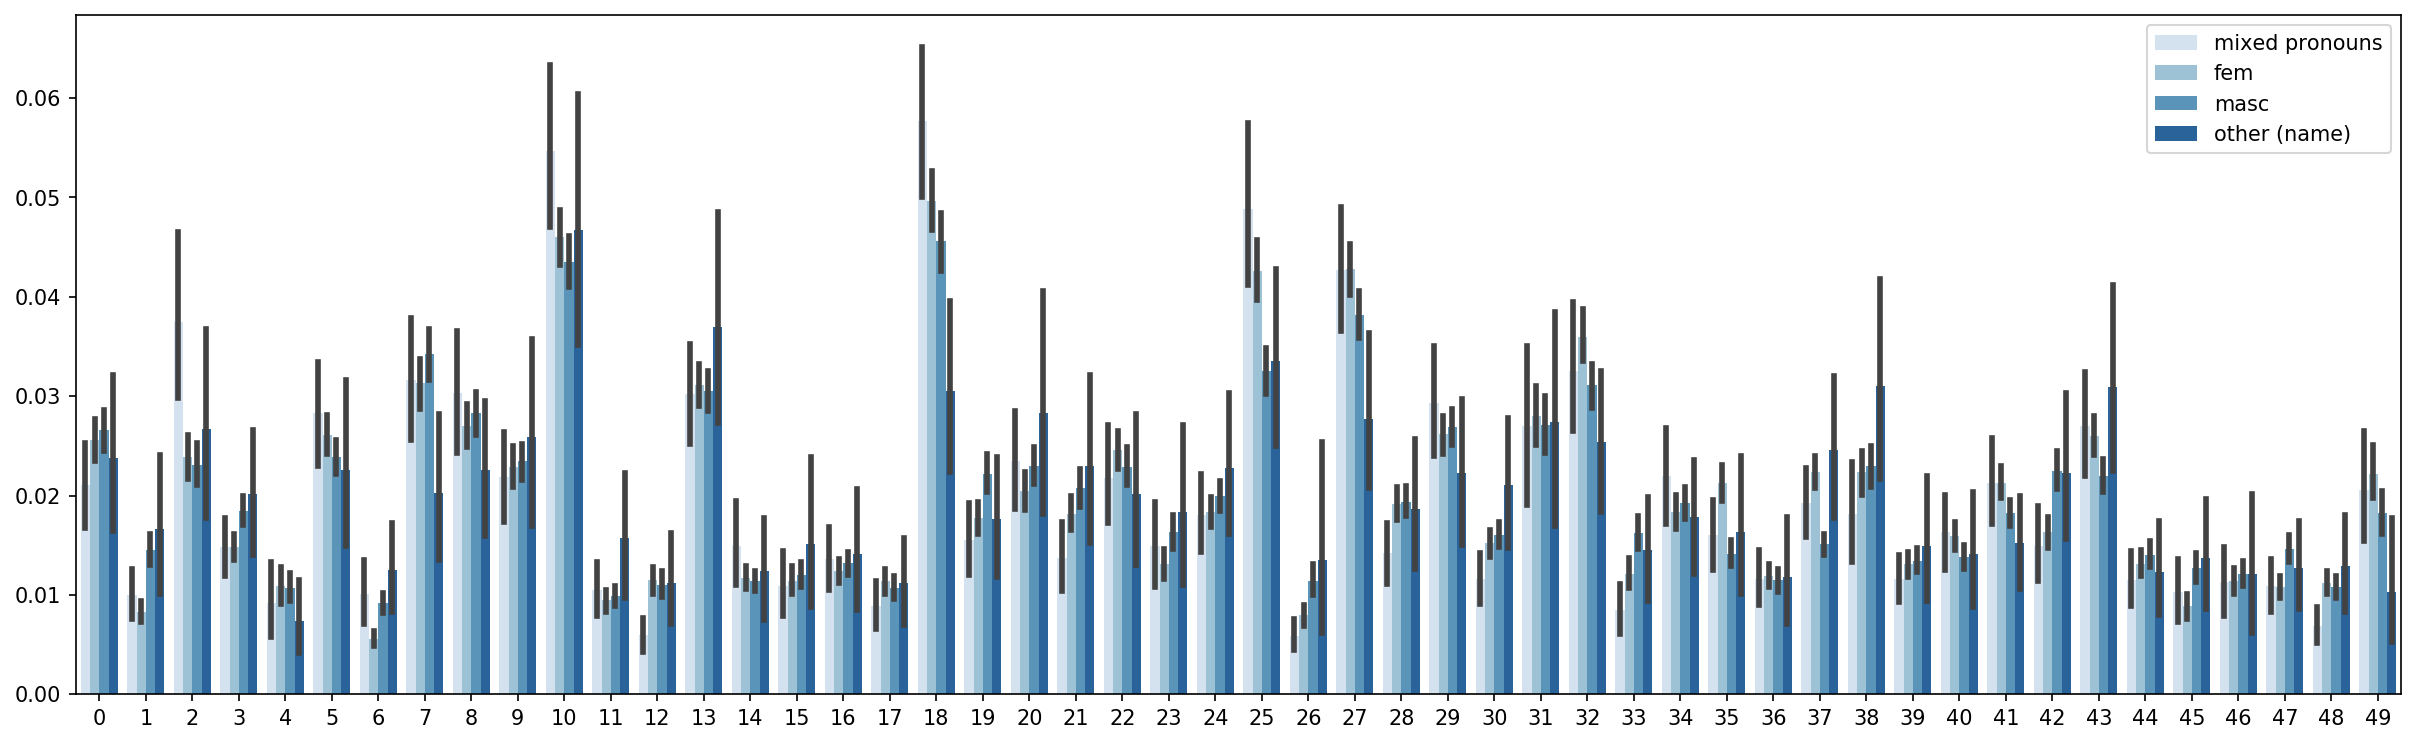

In [318]:
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Blues", hue="gender", data=matched_gender_topics)

In [657]:
# bonferroni correction: 0.05/12, or 0.00417
matched_gender_df = pd.DataFrame(matched_gender_topics)
for i in [33, 1, 23, 37, 35, 25]: 
    fem_prob = matched_gender_df.loc[(matched_gender_df.gender == 'fem') & (matched_gender_df.topic == i)]['value'].to_list()
    masc_prob = matched_gender_df.loc[(matched_gender_df.gender == 'masc') & (matched_gender_df.topic == i)]['value'].to_list()
    print(i, ttest_ind(fem_prob, masc_prob))

33 Ttest_indResult(statistic=-3.2242167894780414, pvalue=0.001268710855123605)
1 Ttest_indResult(statistic=-6.973746517239984, pvalue=3.355078705989165e-12)
23 Ttest_indResult(statistic=-3.8551628985977184, pvalue=0.00011664124199419891)
37 Ttest_indResult(statistic=7.230844072918693, pvalue=5.285215462096842e-13)
35 Ttest_indResult(statistic=6.9335686652339605, pvalue=4.4528775395319075e-12)
25 Ttest_indResult(statistic=5.874928037033927, pvalue=4.415311494373903e-09)


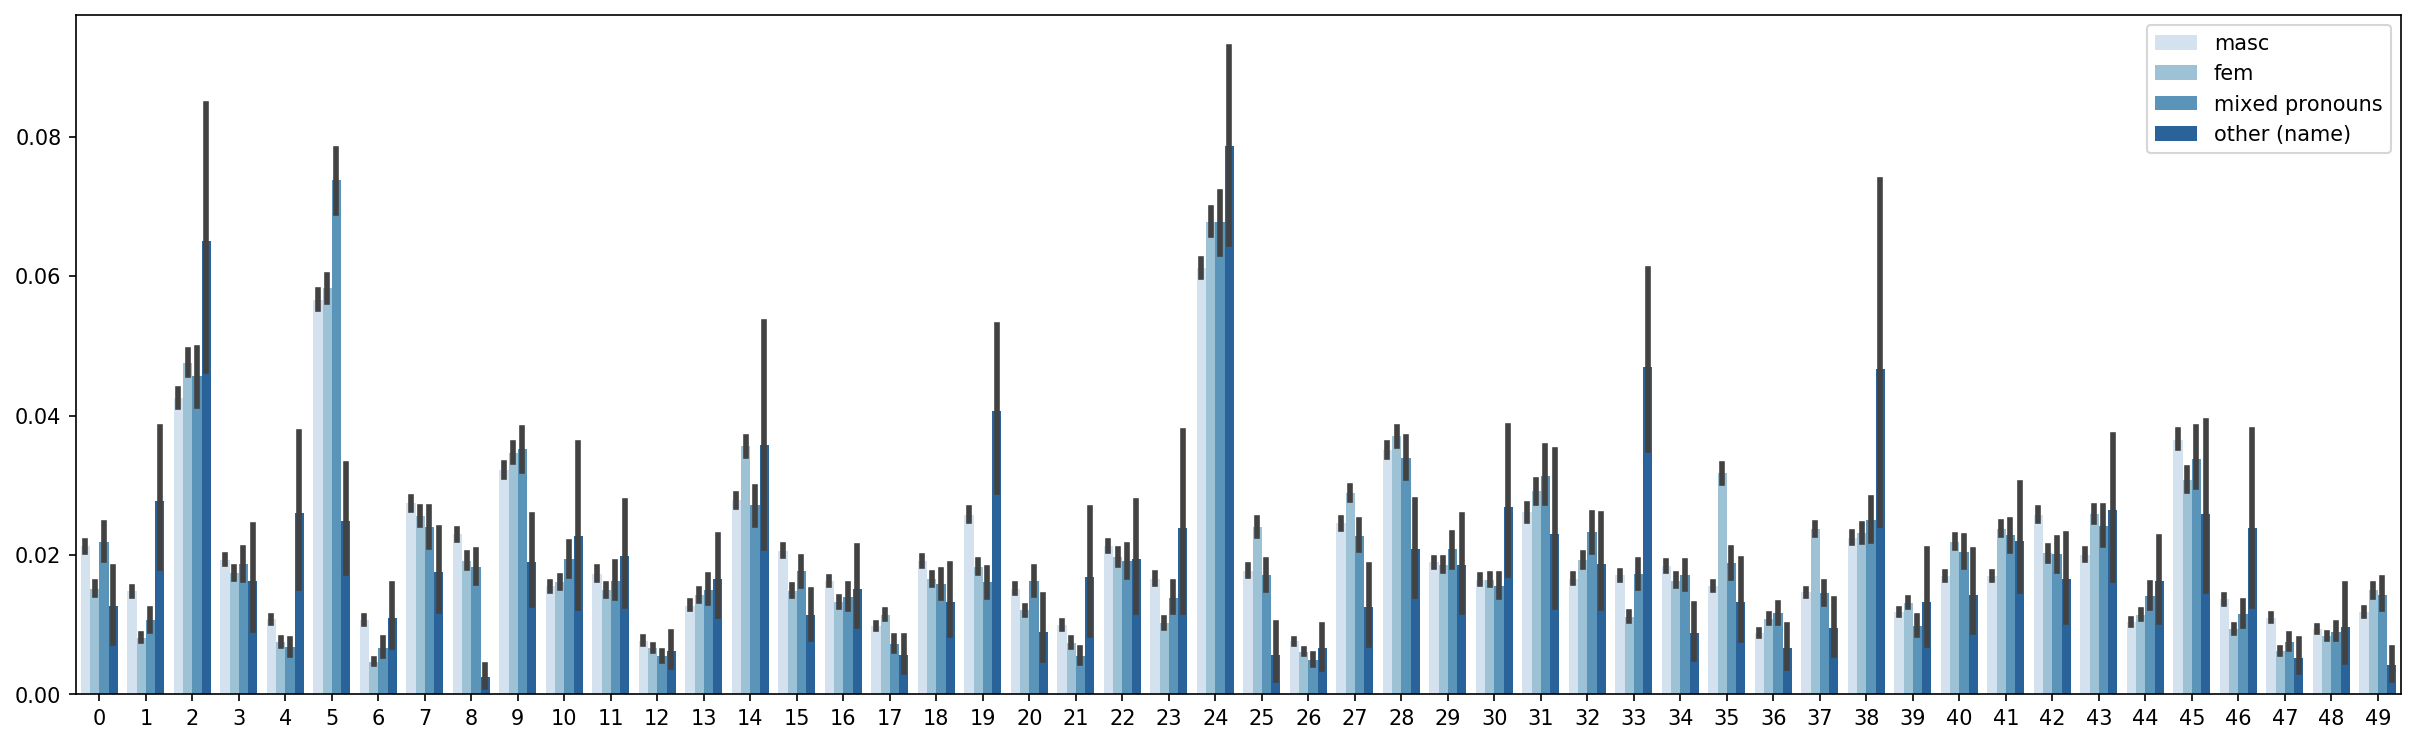

In [319]:
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Blues", hue="gender", data=orig_gender_topics)

In [647]:
gender_df = pd.DataFrame(gen_gender_topics)
gender_df = gender_df.groupby(['gender', 'topic']).mean()
gender_topic_dict = gender_df.to_dict('index')
diffs = {'dataset':[], 'diff':[], 'topic':[]}
gen_diffs = {}
for key in gender_topic_dict: 
    if key[0] == 'fem': 
        topic = key[1]
        fem_val = gender_topic_dict[key]['value']
        masc_val = gender_topic_dict[('masc', topic)]['value']
        diff = fem_val - masc_val
        diffs['dataset'].append('generated')
        diffs['diff'].append(diff)
        diffs['topic'].append(topic)
        gen_diffs[topic] = diff
        
gender_df = pd.DataFrame(orig_gender_topics)
gender_df = gender_df.groupby(['gender', 'topic']).mean()
gender_topic_dict = gender_df.to_dict('index')
orig_diffs = {}
for key in gender_topic_dict: 
    if key[0] == 'fem': 
        topic = key[1]
        fem_val = gender_topic_dict[key]['value']
        masc_val = gender_topic_dict[('masc', topic)]['value']
        diff = fem_val - masc_val
        diffs['dataset'].append('original')
        diffs['diff'].append(diff)
        diffs['topic'].append(topic)
        orig_diffs[topic] = diff
        
gender_df = pd.DataFrame(matched_gender_topics)
gender_df = gender_df.groupby(['gender', 'topic']).mean()
gender_topic_dict = gender_df.to_dict('index')
matched_diffs = {}
for key in gender_topic_dict: 
    if key[0] == 'fem': 
        topic = key[1]
        fem_val = gender_topic_dict[key]['value']
        masc_val = gender_topic_dict[('masc', topic)]['value']
        diff = fem_val - masc_val
        diffs['dataset'].append('matched')
        diffs['diff'].append(diff)
        diffs['topic'].append(topic)
        matched_diffs[topic] = diff

orig_diffs = [tup[1] for tup in sorted(orig_diffs.items(), key=lambda item: item[0])]
gen_diffs = [tup[1] for tup in sorted(gen_diffs.items(), key=lambda item: item[0])]
matched_diffs = [tup[1] for tup in sorted(matched_diffs.items(), key=lambda item: item[0])]

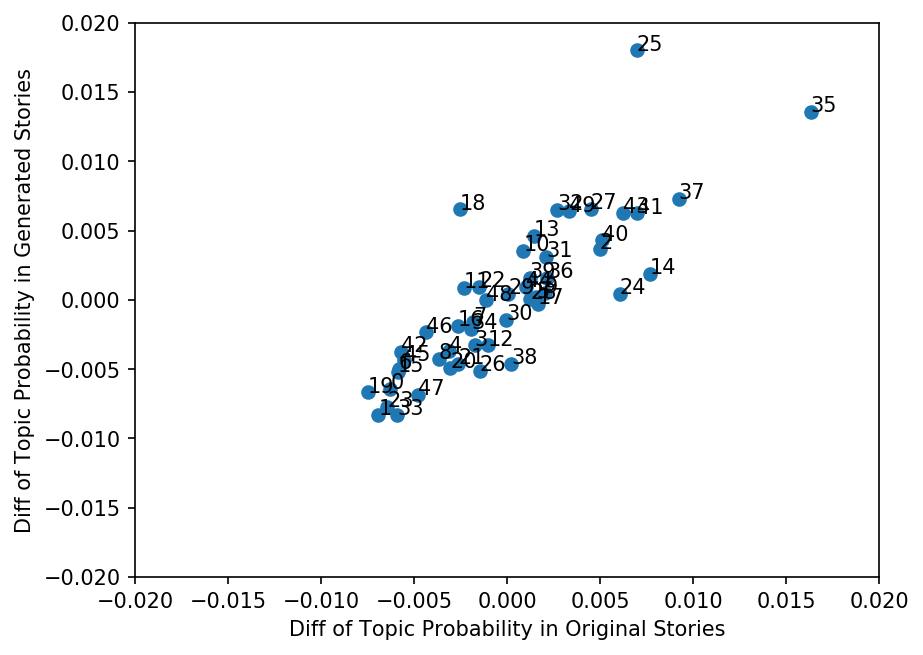

(0.8407233576402686, 2.1991009425878996e-14)


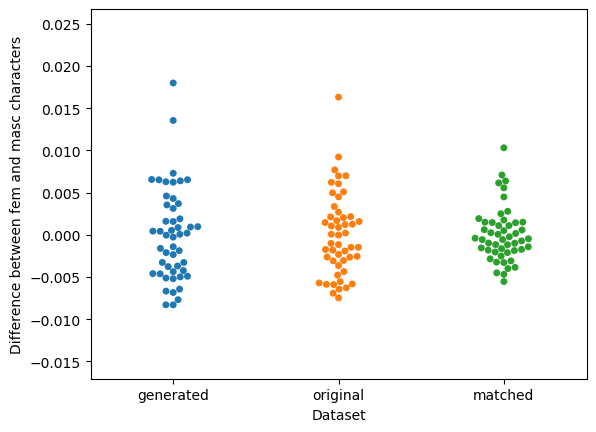

In [648]:
plt.figure(dpi=150)
plt.scatter(orig_diffs, gen_diffs)
for i, txt in enumerate([str(j) for j in range(50)]):
    plt.annotate(txt, (orig_diffs[i], gen_diffs[i]))
plt.ylim(-0.02, 0.02)
plt.xlim(-0.02, 0.02)
plt.xlabel("Diff of Topic Probability in Original Stories")
plt.ylabel("Diff of Topic Probability in Generated Stories")
plt.show()
print(pearsonr(orig_diffs, gen_diffs))
sns.swarmplot(x="dataset", y="diff", data=diffs)
plt.ylabel("Difference between fem and masc characters")
plt.xlabel("Dataset")
plt.show()

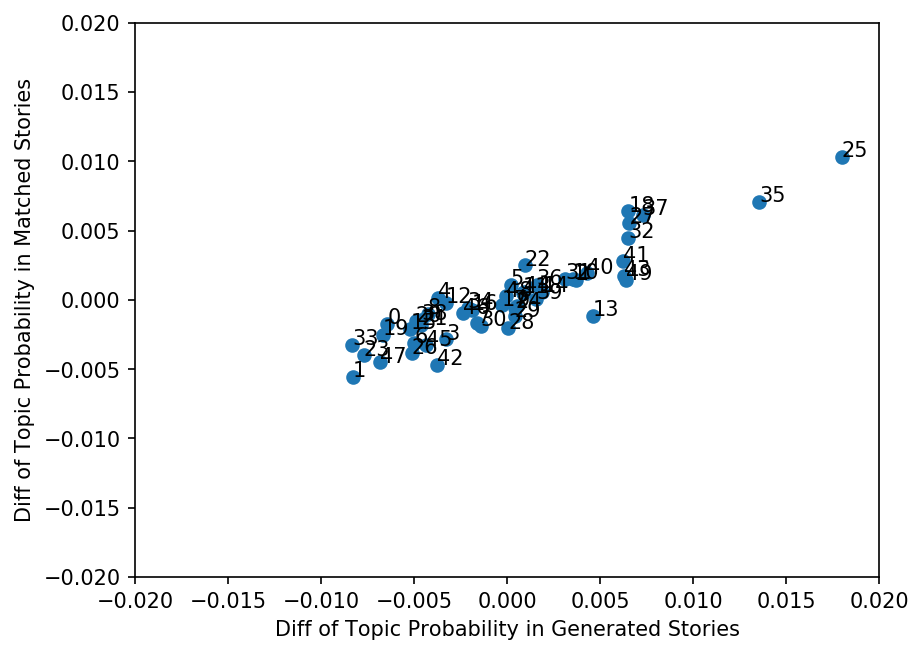

(0.9110054422353413, 4.2932167147894935e-20)


In [649]:
plt.figure(dpi=150)
plt.scatter(gen_diffs, matched_diffs)
for i, txt in enumerate([str(j) for j in range(50)]):
    plt.annotate(txt, (gen_diffs[i], matched_diffs[i]))
plt.ylim(-0.02, 0.02)
plt.xlim(-0.02, 0.02)
plt.xlabel("Diff of Topic Probability in Generated Stories")
plt.ylabel("Diff of Topic Probability in Matched Stories")
plt.show()
print(pearsonr(matched_diffs, gen_diffs))

In [354]:
print(np.argsort(orig_diffs))
print(np.sort(orig_diffs))

[19  1 23  0 33 15  6 42 45 47 46  8  4 20 16 21 18 11 34  7  3 22 26 48
 12 30 29 38 10 44 39 28 13  5 17  9 31 36 32 49 27  2 40 24 43 25 41 14
 37 35]
[-7.47554517e-03 -6.92074912e-03 -6.44507581e-03 -6.28564587e-03
 -5.90250207e-03 -5.87711886e-03 -5.82693694e-03 -5.70682330e-03
 -5.54666188e-03 -4.77578568e-03 -4.35726584e-03 -3.65721421e-03
 -3.09422365e-03 -3.05316551e-03 -2.65308354e-03 -2.63592881e-03
 -2.55565633e-03 -2.32451778e-03 -1.92949468e-03 -1.81962143e-03
 -1.73869639e-03 -1.48226236e-03 -1.47883979e-03 -1.15685707e-03
 -1.01991929e-03 -3.40638384e-05  6.72231453e-05  2.07496653e-04
  8.71951404e-04  1.04211898e-03  1.21390361e-03  1.25230630e-03
  1.45237293e-03  1.57931777e-03  1.67285719e-03  2.02936250e-03
  2.11695583e-03  2.15540083e-03  2.68664414e-03  3.35529543e-03
  4.49494324e-03  4.97238045e-03  5.09151351e-03  6.05183901e-03
  6.21977539e-03  6.98447461e-03  6.99969192e-03  7.69108236e-03
  9.22191573e-03  1.63228323e-02]


In [355]:
print(np.argsort(gen_diffs))
print(np.sort(gen_diffs))
print(np.sort(np.abs(gen_diffs)))
print(np.argsort(np.abs(gen_diffs)))

[33  1 23 47 19  0 15 26  6 20 38 21 45  8 42  4 12  3 46 34 16  7 30 17
 48 28  5 29 24  9 11 44 22 39 36 14 31 10  2 40 13 41 43 49 32 18 27 37
 35 25]
[-8.30901936e-03 -8.30203898e-03 -7.69635621e-03 -6.83981069e-03
 -6.68018445e-03 -6.43947003e-03 -5.20666452e-03 -5.12428921e-03
 -4.98801703e-03 -4.91053034e-03 -4.62743299e-03 -4.60509147e-03
 -4.36721071e-03 -4.24465690e-03 -3.77125400e-03 -3.70470734e-03
 -3.28239422e-03 -3.27770650e-03 -2.34771116e-03 -2.11340357e-03
 -1.88008845e-03 -1.61210106e-03 -1.41674172e-03 -2.77665420e-04
 -4.23083746e-05  5.83945360e-05  1.92981299e-04  4.19634059e-04
  4.32365441e-04  5.23706893e-04  8.56011734e-04  9.19468982e-04
  9.60788528e-04  1.57673325e-03  1.60148537e-03  1.89364307e-03
  3.12155810e-03  3.54147918e-03  3.69847666e-03  4.30353064e-03
  4.59946629e-03  6.23318895e-03  6.29029498e-03  6.39391732e-03
  6.51695968e-03  6.52948335e-03  6.55740251e-03  7.29376661e-03
  1.35534511e-02  1.79986662e-02]
[4.23083746e-05 5.83945360e-05 1

In [356]:
print(np.argsort(matched_diffs))
print(np.sort(matched_diffs))

[ 1 42 47 23 26 45 33  6  3 19 15 28 30 21  0  7 20 38 29 13  8 46 16 24
 34  9 17 12 39  4 48 11 14 44  5 36  2 49 10 31 43 40 22 41 32 27 37 18
 35 25]
[-5.54248196e-03 -4.69120498e-03 -4.51083511e-03 -4.00416853e-03
 -3.86018589e-03 -3.29019536e-03 -3.24308867e-03 -3.09014599e-03
 -2.85822684e-03 -2.52716434e-03 -2.10991670e-03 -2.04842377e-03
 -1.86625547e-03 -1.82108658e-03 -1.73174793e-03 -1.64913631e-03
 -1.55714042e-03 -1.42166738e-03 -1.17947874e-03 -1.15994865e-03
 -1.00315711e-03 -9.78533986e-04 -7.26398470e-04 -5.72082294e-04
 -5.71900897e-04 -4.66838524e-04 -4.02029745e-04 -2.34538297e-04
  5.88967980e-05  1.59549688e-04  2.46903489e-04  4.93958716e-04
  5.71360742e-04  6.04774233e-04  1.08234246e-03  1.08701142e-03
  1.43217986e-03  1.45453285e-03  1.49757389e-03  1.50435849e-03
  1.74748643e-03  1.92207480e-03  2.49696970e-03  2.77642843e-03
  4.48925079e-03  5.56640353e-03  6.14487014e-03  6.38045055e-03
  7.08874464e-03  1.03118573e-02]


In [21]:
gender_df = pd.DataFrame.from_dict(gender_topics)

In [23]:
topic_29 = gender_df[gender_df['topic'] == 29]
#topic_29['value']
topic_29

,gender,topic,value
29,masc,29,0.274048
79,masc,29,0.274048
129,masc,29,0.274048
179,masc,29,0.274048
229,masc,29,0.274048
...,...,...,...
2324779,masc,29,0.274048
2324829,masc,29,0.274048
2324879,masc,29,0.274048
2324929,masc,29,0.274048


### Effect of topic on story

In [7]:
with open(LOGS + 'topics_0.9/' + str(35) + '_prompt_topic_scores.json', 'r') as infile: 
    topic_score_dict1 = json.load(infile)
with open(LOGS + 'topics_0.9/' + str(33) + '_prompt_topic_scores.json', 'r') as infile: 
    topic_score_dict2 = json.load(infile)

### Topic probability in prompt vs topic probability in document

In [115]:
def get_story_topics(): 
    '''
    returns a dictionary of 
    story_title_storyid : {topic_id : topic probability}
    '''
    topic_dir = LOGS + 'topics_0.9' 
    doc_topic_file = '%s/doc-topics.gz' % topic_dir
    doc_topics = open(doc_topic_file).read().splitlines() # list of topics
    story_ids = open(topic_dir + '/story_id_order').read().splitlines() # story IDs 
    story_topics = defaultdict(dict) # story ID : {topic id : value, topic id: value}
    for i, doc in enumerate(doc_topics): 
        contents = doc.split('\t')
        topics = [float(i) for i in contents[2:]]
        story_title_id = story_ids[i]
        if not story_title_id.startswith("ORIG_"):             
            assert len(topics) == 50
            for topic_id, value in enumerate(topics): 
                story_topics[story_title_id][topic_id] = value
    return story_topics

In [116]:
def effect_of_prompt_on_story(topic_id, topic_score_dict): 
    masc_chars = defaultdict(set) # title : set of chars that are masc by pronouns
    fem_chars = defaultdict(set)
    for f in os.listdir(LOGS + 'char_gender_0.9/'): 
        title = f.replace('.json', '')
        with open(LOGS + 'char_gender_0.9/' + f, 'r') as infile: 
            char_neighbors = json.load(infile)
        for char in char_neighbors: 
            # for every main character
            neighbor_dict = char_neighbors[char]
            for neighbor in neighbor_dict: 
                # for every character it co-occurs with 
                gender = neighbor['gender_label']
                neighbor_n = neighbor['character_name']
                pronoun_count = len(neighbor['gender'])
                story_ID = int(neighbor_n.split('_')[-1])
                if neighbor_n in topic_score_dict[title]: 
                    # main character
                    if gender == 'masc': 
                        masc_chars[title].add(neighbor_n)
                    if gender == 'fem': 
                        fem_chars[title].add(neighbor_n)
    story_topics = get_story_topics()
    x = []
    y = []
    z = []
    for title in topic_score_dict: 
        for char_ID in topic_score_dict[title]: 
            story_ID = int(char_ID.split('_')[-1])
            prompt_prob = topic_score_dict[title][char_ID]
            story_title_id = title + str(story_ID + 1)
            topic_dict = story_topics[story_title_id]
            story_prob = topic_dict[topic_id] 
            x.append(prompt_prob)
            y.append(story_prob)
            if char_ID in masc_chars[title]: 
                z.append('masc')
            elif char_ID in fem_chars[title]: 
                z.append('fem')
            else: 
                z.append('other')
    return x, y, z

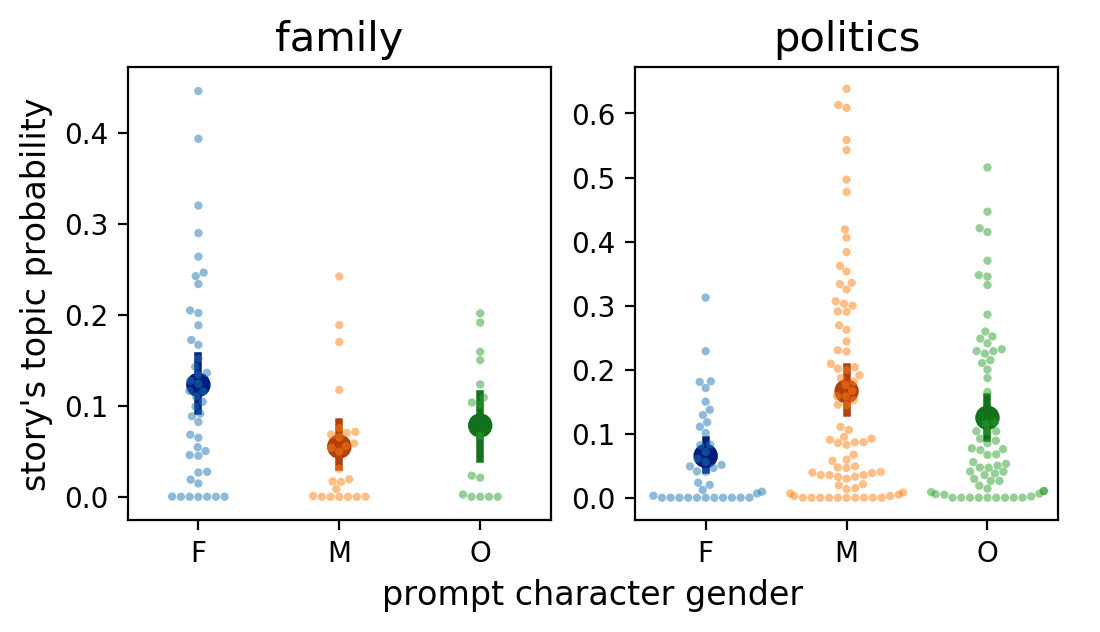

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("prompt character gender", fontsize=12)
plt.ylabel("story\'s topic probability", fontsize=12)

x, y, z = effect_of_prompt_on_story(35, topic_score_dict1)
prob_d = {'prompt prob': x, 'story prob': y, 'gender': z}
prob_df = pd.DataFrame.from_dict(prob_d)
prob_df = prob_df[prob_df['prompt prob'] > 0.15]
sns.swarmplot(ax=axes[0], x="gender", y="story prob", data=prob_df, alpha=.5, size=3, order=['fem', 'masc', 'other'])
sns.pointplot(ax=axes[0], x="gender", y="story prob",
              data=prob_df, join=False, palette="dark", order=['fem', 'masc', 'other'])
axes[0].get_xaxis().set_ticklabels(['F', 'M', 'O'])
axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[0].set_title('family', fontsize=15)

x, y, z = effect_of_prompt_on_story(33, topic_score_dict2)
prob_d = {'prompt prob': x, 'story prob': y, 'gender': z}
prob_df = pd.DataFrame.from_dict(prob_d)
prob_df = prob_df[prob_df['prompt prob'] > 0.15]
sns.swarmplot(ax=axes[1], x="gender", y="story prob", data=prob_df, alpha=.5, size=3, order=['fem', 'masc', 'other'])
sns.pointplot(ax=axes[1], x="gender", y="story prob",
              data=prob_df, join=False, palette="dark", order=['fem', 'masc', 'other'])
axes[1].get_xaxis().set_ticklabels(['F', 'M', 'O'])
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_title('politics', fontsize=15)
plt.show()

In [35]:
x, y, z = effect_of_prompt_on_story(35, topic_score_dict1)
print(pearsonr(x, y))
print(np.percentile(x, 99.9))

(0.11714909591740269, 0.0)
0.12992424242423078


## Lexicons

In [72]:
def read_stereotypes(): 
    inpath = '/mnt/data0/corpora/lexicons/fast_icwsm_2016_gender_stereotypes.csv'
    labels = set(['weak', 'dependent', 'submissive', 'afraid', 'strong', 'dominant', 'beautiful', 'sexual'])
    lexicons = defaultdict(set)
    with open(inpath, 'r') as infile: 
        reader = csv.DictReader(infile, delimiter=',')
        for row in reader: 
            for key in row:
                if row[key] == '': continue 
                if key in labels: 
                    lexicons[key].add(row[key])
    inpath = '/mnt/data0/corpora/lexicons/empath_categories.tsv'
    with open(inpath, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('\t')
            if 'intellectual' in contents: 
                for w in contents: 
                    lexicons['intellectual'].add(w)
    for key in lexicons: 
        lexicons[key].add(key)
        
    axes_A1 = ['strong', 'dominant']
    axes_A2 = ['weak', 'dependent', 'submissive', 'afraid']
    axes_B1 = ['beautiful', 'sexual']
    axes_B2 = ['intellectual']
    lexicon_d  = defaultdict(set)
    lexicon_d['strong'] = lexicons['strong'] | lexicons['dominant']
    for cat in axes_A2: 
        lexicon_d['weak'] |= lexicons[cat]
    lexicon_d['physical'] = lexicons['beautiful'] | lexicons['sexual']
    lexicon_d['intellectual'] = lexicons['intellectual']
    return lexicon_d

In [73]:
lexicon_d = read_stereotypes()

In [74]:
for k in lexicon_d: print(k, len(lexicon_d[k]))

strong 113
weak 141
physical 201
intellectual 98


### Similarity scores

Print out adjectives and verbs with highest scores for each stereotype category

In [643]:
with open(LOGS + 'intellect_scores.json', 'r') as infile: 
    intellect_scores = Counter(json.load(infile))
print(intellect_scores.most_common(20), '\n')
with open(LOGS + 'physical_scores.json', 'r') as infile: 
    physical_scores = Counter(json.load(infile))
print(physical_scores.most_common(20), '\n')
with open(LOGS + 'strength_scores.json', 'r') as infile: 
    strength_scores = Counter(json.load(infile))
sorted_strength = strength_scores.most_common()
print(sorted_strength[:20], '\n')
print(sorted_strength[-20:], '\n')

[('intellectual', 0.565263569355011), ('aesthetic', 0.531465470790863), ('moral', 0.5274004936218262), ('artistic', 0.5271057486534119), ('progressive', 0.5259044766426086), ('values', 0.5202677249908447), ('spiritual', 0.5173299312591553), ('secular', 0.5044122338294983), ('religious', 0.500640332698822), ('imaginative', 0.5004410147666931), ('scientific', 0.4996270537376404), ('marxist', 0.49501365423202515), ('revolutionary', 0.49355006217956543), ('political', 0.49316367506980896), ('radical', 0.4918311834335327), ('creative', 0.49179786443710327), ('academic', 0.49019569158554077), ('metaphysical', 0.4863678812980652), ('fanatical', 0.48373615741729736), ('humanitarian', 0.4801952838897705)] 

[('sensual', 0.29684576392173767), ('beautiful', 0.2961128056049347), ('gorgeous', 0.29289957880973816), ('flawless', 0.2922338545322418), ('manly', 0.2828841209411621), ('charming', 0.2827223837375641), ('seductive', 0.28182563185691833), ('womanly', 0.28101828694343567), ('enticing', 0.281

### Generated

In [580]:
def get_lexicon_dict(genpath): 
    d = {'gender':[], 'lexicon':[], 'value':[]}
    for f in os.listdir(genpath):
        title = f.replace('.tokens', '')
        gen_word = Counter() # (gender, lexicon) : value
        with open(genpath + f, 'r') as infile: 
            for line in infile: 
                contents = line.strip().split('\t')
                w = contents[0]
                deprel = contents[3]
                hw = contents[5]
                storyid = contents[7]
                gender = contents[8]
                if gender == 'mixed pronouns' or gender == 'other (name)': 
                    gender = 'other'
                if deprel == 'amod': 
                    keyword = w
                elif deprel == 'nsubj': 
                    keyword = hw

                d['gender'].append(gender)
                d['lexicon'].append('intellectual')
                d['value'].append(intellect_scores[keyword])

                d['gender'].append(gender)
                d['lexicon'].append('appearance')
                d['value'].append(physical_scores[keyword])

                d['gender'].append(gender)
                d['lexicon'].append('power')
                d['value'].append(strength_scores[keyword])
    return d

In [578]:
def run_significance_tests(df): 
    fem_intell = df.loc[(df.gender == 'fem') & (df.lexicon =='intellectual')]['value'].to_list()
    masc_intell = df.loc[(df.gender == 'masc') & (df.lexicon =='intellectual')]['value'].to_list()
    print("Intellect:", ttest_ind(fem_intell, masc_intell))
    fem_phy = df.loc[(df.gender == 'fem') & (df.lexicon =='appearance')]['value'].to_list()
    masc_phy = df.loc[(df.gender == 'masc') & (df.lexicon =='appearance')]['value'].to_list()
    print("Appearance:", ttest_ind(fem_phy, masc_phy))
    fem_power = df.loc[(df.gender == 'fem') & (df.lexicon =='power')]['value'].to_list()
    masc_power = df.loc[(df.gender == 'masc') & (df.lexicon =='power')]['value'].to_list()
    print("Power:", ttest_ind(fem_power, masc_power))

In [618]:
gen_d = get_lexicon_dict(LOGS + 'generated_adj_noun/')
gen_df = pd.DataFrame.from_dict(gen_d)
gen_df

,gender,lexicon,value
0,masc,intellectual,0.041816
1,masc,appearance,0.003559
2,masc,power,-0.014162
3,masc,intellectual,0.070517
4,masc,appearance,0.035518
...,...,...,...
5667640,fem,appearance,0.013893
5667641,fem,power,-0.017887
5667642,fem,intellectual,-0.157123
5667643,fem,appearance,-0.039087


In [582]:
gen_stats = gen_df.groupby(['gender', 'lexicon']).agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in gen_stats.index:
    m, c, s = gen_stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

gen_stats['ci95_hi'] = ci95_hi
gen_stats['ci95_lo'] = ci95_lo
print(gen_stats)

                        value                      ci95_hi   ci95_lo
                         mean    count       std                    
gender lexicon                                                      
fem    appearance    0.030427   727207  0.049270  0.030540  0.030314
       intellectual -0.003288   727207  0.105896 -0.003044 -0.003531
       power        -0.115664   727207  0.140982 -0.115340 -0.115988
masc   appearance    0.027893  1111140  0.047495  0.027981  0.027805
       intellectual -0.004567  1111140  0.107056 -0.004368 -0.004766
       power        -0.106867  1111140  0.141478 -0.106604 -0.107130
other  appearance    0.027686    50868  0.043812  0.028066  0.027305
       intellectual -0.019822    50868  0.098020 -0.018970 -0.020674
       power        -0.140023    50868  0.137581 -0.138827 -0.141218


In [583]:
run_significance_tests(gen_df)

Intellect: Ttest_indResult(statistic=7.954796800513488, pvalue=1.795265418900012e-15)
Appearance: Ttest_indResult(statistic=34.85132949062918, pvalue=4.9689875098418354e-266)
Power: Ttest_indResult(statistic=-41.283281851455456, pvalue=0.0)


### Matched

The 40 cases of "other" here are uses of the pronoun "they"

In [619]:
m_d = get_lexicon_dict(LOGS + 'matched_adj_noun/')
m_df = pd.DataFrame.from_dict(m_d)
m_df

,gender,lexicon,value
0,masc,intellectual,-0.040177
1,masc,appearance,0.017319
2,masc,power,-0.043120
3,masc,intellectual,0.032542
4,masc,appearance,0.045874
...,...,...,...
394540,fem,appearance,0.031622
394541,fem,power,0.007793
394542,fem,intellectual,0.043719
394543,fem,appearance,0.008737


In [585]:
m_stats = m_df.groupby(['gender', 'lexicon']).agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in m_stats.index:
    m, c, s = m_stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

m_stats['ci95_hi'] = ci95_hi
m_stats['ci95_lo'] = ci95_lo
print(m_stats)

                        value                    ci95_hi   ci95_lo
                         mean  count       std                    
gender lexicon                                                    
fem    appearance    0.029528  66112  0.048579  0.029898  0.029157
       intellectual -0.005382  66112  0.105922 -0.004574 -0.006189
       power        -0.115385  66112  0.141468 -0.114307 -0.116463
masc   appearance    0.027968  65363  0.047192  0.028330  0.027606
       intellectual -0.004399  65363  0.106937 -0.003579 -0.005218
       power        -0.106882  65363  0.142537 -0.105789 -0.107975
other  appearance    0.030017     40  0.063946  0.049834  0.010200
       intellectual  0.042784     40  0.104228  0.075085  0.010484
       power        -0.052699     40  0.129320 -0.012622 -0.092776


In [586]:
run_significance_tests(m_df)

Intellect: Ttest_indResult(statistic=-1.6750308133256524, pvalue=0.09393056433734673)
Appearance: Ttest_indResult(statistic=5.903070193733489, pvalue=3.5766984679705763e-09)
Power: Ttest_indResult(statistic=-10.855747223047382, pvalue=1.9236296000809943e-27)


### Original books

In [587]:
orig_d = get_lexicon_dict(LOGS + 'orig_adj_noun/')

In [620]:
orig_df = pd.DataFrame.from_dict(orig_d)
o_stats = orig_df.groupby(['gender', 'lexicon']).agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in o_stats.index:
    m, c, s = o_stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

o_stats['ci95_hi'] = ci95_hi
o_stats['ci95_lo'] = ci95_lo
print(o_stats)

                        value                     ci95_hi   ci95_lo
                         mean   count       std                    
gender lexicon                                                     
fem    appearance    0.031967  168464  0.051197  0.032211  0.031722
       intellectual  0.005528  168464  0.110372  0.006055  0.005001
       power        -0.096962  168464  0.147189 -0.096259 -0.097665
masc   appearance    0.029247  287495  0.049329  0.029428  0.029067
       intellectual  0.002395  287495  0.110806  0.002800  0.001990
       power        -0.090917  287495  0.146876 -0.090380 -0.091454
other  appearance    0.029436    8504  0.050238  0.030504  0.028368
       intellectual -0.006459    8504  0.109373 -0.004134 -0.008783
       power        -0.106025    8504  0.148763 -0.102863 -0.109186


In [589]:
run_significance_tests(orig_df)

Intellect: Ttest_indResult(statistic=9.228212716663284, pvalue=2.7630704605887875e-20)
Appearance: Ttest_indResult(statistic=17.716410664947546, pvalue=3.307668885659681e-70)
Power: Ttest_indResult(statistic=-13.402773036874601, pvalue=5.929656937364132e-41)


In [621]:
orig_df['dataset'] = 'books'
gen_df['dataset'] = 'all\nGPT-3'
all_df = pd.concat([orig_df, gen_df])
a_average = np.mean(all_df[all_df['lexicon'] == 'appearance']['value'].to_list())
a_std = np.std(all_df[all_df['lexicon'] == 'appearance']['value'].to_list())
i_average = np.mean(all_df[all_df['lexicon'] == 'intellectual']['value'].to_list())
i_std = np.std(all_df[all_df['lexicon'] == 'intellectual']['value'].to_list())
p_average = np.mean(all_df[all_df['lexicon'] == 'power']['value'].to_list())
p_std = np.std(all_df[all_df['lexicon'] == 'power']['value'].to_list())

m_df = m_df[m_df['gender'] != 'other'] 
m_df['dataset'] = 'matched\nGPT-3'
df = pd.concat([orig_df, gen_df, m_df])

a_df = df[df['lexicon'] == 'appearance']
a_df['value'] = (a_df['value'] - a_average) / a_std

i_df = df[df['lexicon'] == 'intellectual']
i_df['value'] = (i_df['value'] - i_average) / i_std

p_df = df[df['lexicon'] == 'power']
p_df['value'] = (p_df['value'] - p_average) / p_std

/mnt/data0/lucy/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/mnt/data0/lucy/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/mnt/data0/lucy/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

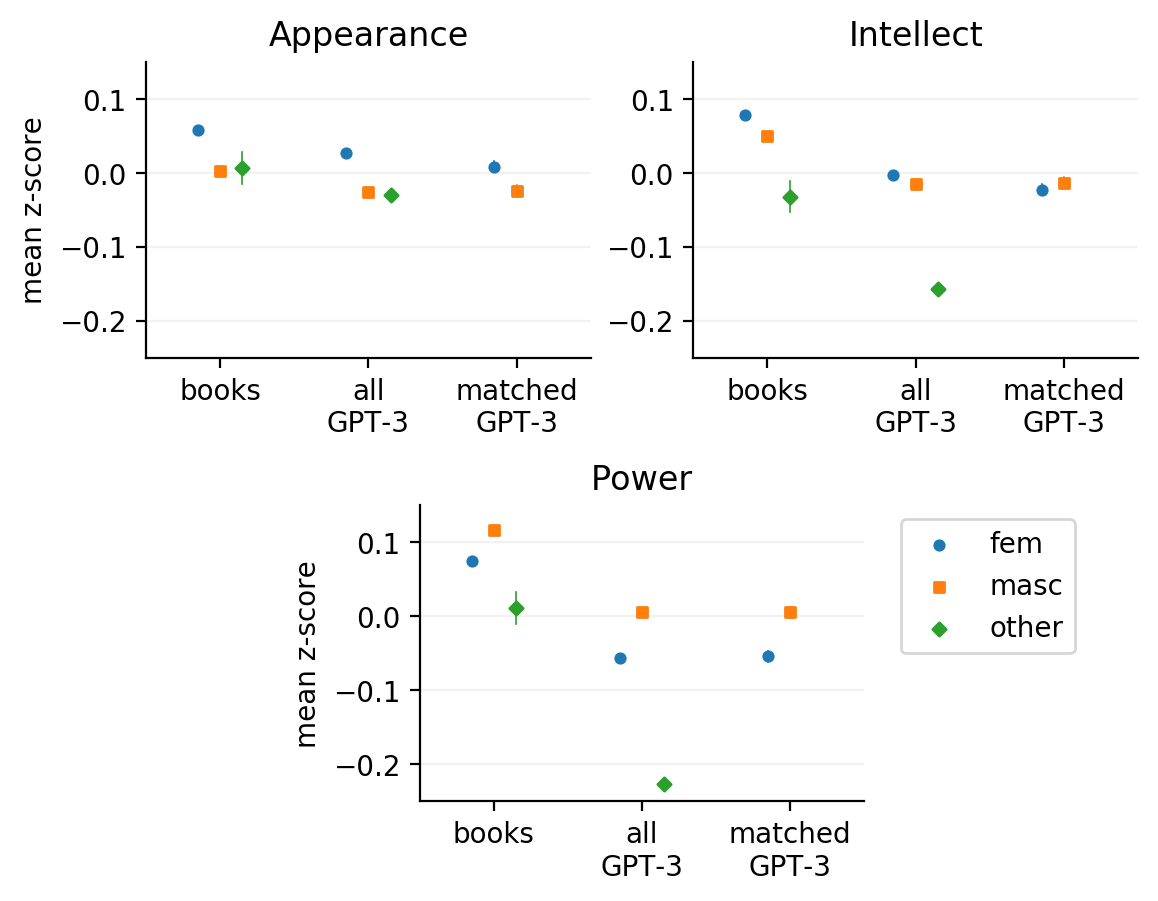

In [625]:
verb_fig = plt.figure(dpi=200)
gs = gridspec.GridSpec(2, 4, figure=verb_fig)
gs.update(wspace=0.6, hspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

sns.pointplot(ax=ax1, x="dataset", y="value", hue="gender", hue_order=['fem', 'masc', 'other'],
              data=a_df, markers=['o', 's', 'D'], errwidth=0.6, dodge=.3, 
              join=False, scale=0.5)
#ax1.set_ylim(-0.015, 0.05)
ax1.set_ylim(-0.25, 0.15)
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='0.95')
ax1.set_title("Appearance")
ax1.set_ylabel("mean z-score")
ax1.get_legend().remove()
ax1.get_xaxis().label.set_visible(False)

sns.pointplot(ax=ax2, x="dataset", y="value", hue="gender", hue_order=['fem', 'masc', 'other'],
              data=i_df, markers=['o', 's', 'D'], errwidth=0.6, dodge=.3, 
              join=False, scale=0.5)
#ax2.set_ylim(-0.045, 0.02)
ax2.set_ylim(-0.25, 0.15)
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='0.95')
ax2.set_title("Intellect")
ax2.get_legend().remove()
ax2.get_xaxis().label.set_visible(False)
ax2.get_yaxis().label.set_visible(False)

sns.pointplot(ax=ax3, x="dataset", y="value", hue="gender", hue_order=['fem', 'masc', 'other'],
              data=p_df, dodge=.3, markers=['o', 's', 'D'], errwidth=0.6, 
              join=False, scale=0.5)
#ax3.set_ylim(-0.145, -0.08)
ax3.set_ylim(-0.25, 0.15)
ax3.set_axisbelow(True)
ax3.grid(axis='y', color='0.95')
ax3.set_title("Power")
ax3.set_ylabel("mean z-score")
ax3.get_xaxis().label.set_visible(False)
ax3.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

sns.despine()
plt.subplots_adjust(hspace=0.3)
plt.show()

### Anti-stereotype

In [626]:
def get_anti_stereotype_prompts(prompt_design_verbs, verb_type, genpath): 
    title_storyidx = set()
    for title_charID in prompt_design_verbs[verb_type]: 
        contents = title_charID.split('#')
        title = contents[0]
        storyidx = contents[1].split('_')[-1]
        title_storyidx.add((title, storyidx))
    d = {'gender':[], 'lexicon':[], 'value':[]}
    for f in os.listdir(genpath):
        title = f.replace('.tokens', '')
        gen_word = Counter() # (gender, lexicon) : value
        with open(genpath + f, 'r') as infile: 
            for line in infile: 
                contents = line.strip().split('\t')
                w = contents[0]
                deprel = contents[3]
                hw = contents[5]
                storyid = contents[7]
                gender = contents[8]
                if gender == 'mixed pronouns' or gender == 'other (name)': 
                    gender = 'other'
                if (title, storyid) not in title_storyidx: 
                    continue
                if deprel == 'amod': 
                    keyword = w
                elif deprel == 'nsubj': 
                    keyword = hw 
                d['gender'].append(gender)
                d['lexicon'].append('intellectual')
                d['value'].append(intellect_scores[keyword])

                d['gender'].append(gender)
                d['lexicon'].append('appearance')
                d['value'].append(physical_scores[keyword])

                d['gender'].append(gender)
                d['lexicon'].append('power')
                d['value'].append(strength_scores[keyword])
    return d

In [627]:
with open(LOGS + 'prompt_design_verbs.json', 'r') as infile: 
    prompt_design_verbs = json.load(infile)

In [628]:
power_d = get_anti_stereotype_prompts(prompt_design_verbs, 'power', LOGS + 'generated_adj_noun/')
power_df = pd.DataFrame.from_dict(power_d)
power_df

,gender,lexicon,value
0,masc,intellectual,-0.154434
1,masc,appearance,-0.053362
2,masc,power,-0.118964
3,masc,intellectual,-0.154434
4,masc,appearance,-0.053362
...,...,...,...
1219570,fem,appearance,0.046329
1219571,fem,power,-0.135303
1219572,fem,intellectual,-0.033533
1219573,fem,appearance,0.050681


In [629]:
power_stats = power_df.groupby(['gender', 'lexicon']).agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in power_stats.index:
    m, c, s = power_stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

power_stats['ci95_hi'] = ci95_hi
power_stats['ci95_lo'] = ci95_lo
print(power_stats)

                        value                     ci95_hi   ci95_lo
                         mean   count       std                    
gender lexicon                                                     
fem    appearance    0.029398  146761  0.049031  0.029649  0.029148
       intellectual -0.005097  146761  0.106342 -0.004552 -0.005641
       power        -0.111332  146761  0.141107 -0.110610 -0.112054
masc   appearance    0.026565  248961  0.047305  0.026750  0.026379
       intellectual -0.007156  248961  0.107549 -0.006733 -0.007578
       power        -0.102361  248961  0.141472 -0.101806 -0.102917
other  appearance    0.025129   10803  0.044201  0.025962  0.024295
       intellectual -0.022203   10803  0.101986 -0.020280 -0.024127
       power        -0.121520   10803  0.141972 -0.118843 -0.124197


In [630]:
int_d = get_anti_stereotype_prompts(prompt_design_verbs, 'cognitive', LOGS + 'generated_adj_noun/')
int_df = pd.DataFrame.from_dict(int_d)
int_df

,gender,lexicon,value
0,masc,intellectual,-0.095945
1,masc,appearance,0.041097
2,masc,power,-0.309015
3,masc,intellectual,-0.154434
4,masc,appearance,-0.053362
...,...,...,...
65578,fem,appearance,-0.008195
65579,fem,power,-0.275690
65580,fem,intellectual,0.091525
65581,fem,appearance,0.015293


In [631]:
int_stats = int_df.groupby(['gender', 'lexicon']).agg(['mean', 'count', 'std'])

ci95_hi = []
ci95_lo = []

for i in int_stats.index:
    m, c, s = int_stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

int_stats['ci95_hi'] = ci95_hi
int_stats['ci95_lo'] = ci95_lo
print(int_stats)

                        value                    ci95_hi   ci95_lo
                         mean  count       std                    
gender lexicon                                                    
fem    appearance    0.033024   7688  0.049020  0.034120  0.031928
       intellectual  0.011307   7688  0.107807  0.013717  0.008897
       power        -0.106351   7688  0.143386 -0.103146 -0.109556
masc   appearance    0.028026  13675  0.047475  0.028822  0.027230
       intellectual  0.007948  13675  0.109930  0.009791  0.006106
       power        -0.092674  13675  0.148117 -0.090191 -0.095156
other  appearance    0.033367    498  0.042549  0.037104  0.029630
       intellectual  0.011976    498  0.118080  0.022347  0.001605
       power        -0.087996    498  0.160439 -0.073905 -0.102088


In [632]:
run_significance_tests(int_df)

Intellect: Ttest_indResult(statistic=2.158046591368102, pvalue=0.030935317828745056)
Appearance: Ttest_indResult(statistic=7.298795045276323, pvalue=3.0051652674505123e-13)
Power: Ttest_indResult(statistic=-6.552418035839809, pvalue=5.790327476715202e-11)


In [633]:
int_df2 = int_df[int_df['lexicon'] == 'intellectual']
int_df2['dataset'] = 'cognitive verbs'
int_df3 = pd.concat([int_df2, gen_df[gen_df['lexicon'] == 'intellectual']])
int_df3['value'] = (int_df3['value'] - i_average) / i_std

/mnt/data0/lucy/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [634]:
power_df2 = power_df[power_df['lexicon'] == 'power']
power_df2['dataset'] = 'power verbs'
power_df3 = pd.concat([power_df2, gen_df[gen_df['lexicon'] == 'power']])
power_df3['value'] = (power_df3['value'] - p_average) / p_std

/mnt/data0/lucy/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


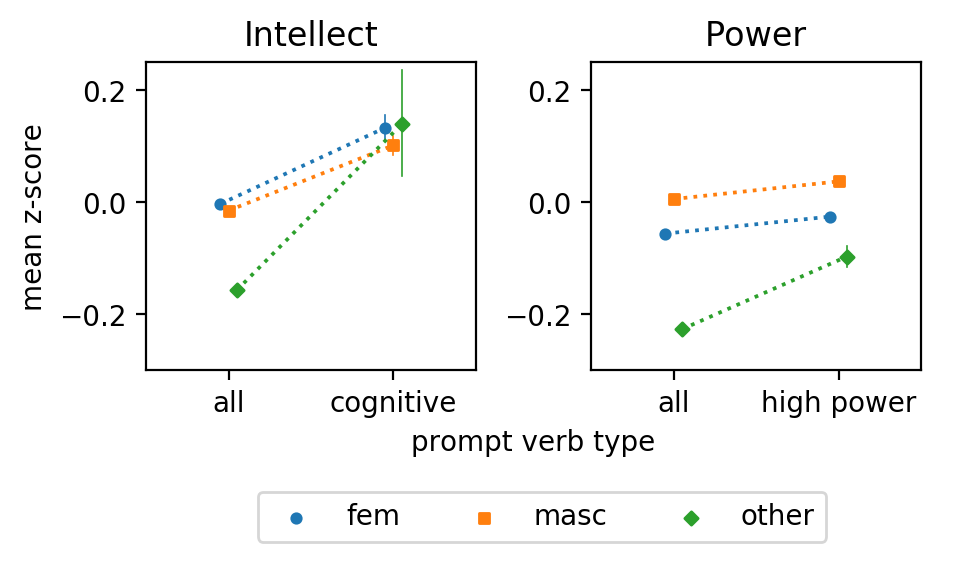

In [640]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2), dpi=200)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("prompt verb type")

sns.pointplot(ax=axes[0], x="dataset", y="value", hue="gender", order=['all\nGPT-3', 'cognitive verbs'], 
              hue_order=['fem', 'masc', 'other'], markers=['o', 's', 'D'], errwidth=0.6,
              data=int_df3, dodge=.1, linestyles=':', scale=0.5)
axes[0].get_legend().remove()
axes[0].set_ylim(-0.3, 0.25)
axes[0].set_title("Intellect")
axes[0].get_xaxis().label.set_visible(False)
axes[0].set_ylabel('mean z-score')
axes[0].get_xaxis().set_ticklabels(['all', 'cognitive'])

sns.pointplot(ax=axes[1], x="dataset", y="value", hue="gender", order=['all\nGPT-3', 'power verbs'],
              hue_order=['fem', 'masc', 'other'], markers=['o', 's', 'D'], errwidth=0.6,
              data=power_df3, dodge=.1, linestyles=':', scale=0.5)
axes[1].legend(loc='upper center', ncol=3, bbox_to_anchor=(-0.15, -0.35))
axes[1].set_title("Power")
axes[1].set_ylim(-0.3, 0.25)
axes[1].get_xaxis().label.set_visible(False)
axes[1].get_yaxis().label.set_visible(False)
axes[1].get_xaxis().set_ticklabels(['all', 'high power'])
plt.subplots_adjust(wspace=0.35)
plt.show()